In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# Agregar la carpeta 'src' al sistema de rutas
sys.path.append(os.path.abspath('../src'))
# Ahora puedes importar el archivo o los módulos
from Tablas_mortalidad import *
from finanzas import *
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')

C:\Users\z079355\AppData\Local\Temp\ipykernel_10932\3093777045.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
ruta=r'../src/datos_longevidad.xlsx'
data=pd.read_excel(ruta,'Data')
print(data.columns)
data=data[['Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja','Pago_mensual']]
data.head()

Index(['Unnamed: 0', 'Edad', 'Casado', 'Genero', 'Edad_pareja', 'Sexo_pareja',
       'Pago_mensual'],
      dtype='object')


,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual
0,68,0,M,0,0,"4,196,583.06"
1,67,1,H,67,H,"1,983,941.40"
2,80,1,H,77,H,"4,014,628.81"
3,71,1,H,85,M,"5,710,179.97"
4,66,0,M,0,0,"7,882,172.76"


In [4]:
ruta_m=r'../src/TM_mujeres.xlsx'
ruta_h=r'../src/TM_hombres.xlsx'
Tmort_m=pd.read_excel(ruta_m)
Tmort_h=pd.read_excel(ruta_h)
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

#Renta vitalicia
$$ V_{a}=\sum_{n=1}^{\left(w-x\right)*12}C*\left(\frac{1}{1+i}\right)^n * P_{x+\frac{n-1}{12}} $$

$$ w\,edad\,maxima\,Tabla $$
$$ x ,\,edad\,actual\,jubilado$$

#Renta vitalicia reversible
$$ V_{a}=\sum_{n=1}^{\left(w-x1\right)*12}C*\left(\frac{1}{1+i}\right)^n * P_{x1+\frac{n-1}{12}} + 
\sum_{n=1}^{\left(w-x2\right)*12}C*\left(\frac{1}{1+i}\right)^n *q_{x1+\frac{n-1}{12}} *P_{x2+\frac{n-1}{12}} $$

$$ w\,edad\,maxima\,Tabla $$
$$ x1 ,\,edad\,actual\,jubilado$$
$$ x2 ,\,edad\,actual\,pareja$$
$$ C ,\,pago$$

In [5]:
valoracion_jubilado =[]
valoracion_pareja=[]
i=0.04/12
for index, row in data.iterrows():

    genero=row['Genero']

    if genero=='H':
        tmort=T_hombre
    else:
        tmort=T_mujer

    if row['Casado']==0:

        #Renta Vitalicia
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()
        va_pareja=0

        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)
      
        
    elif row['Casado']==1:

        #Renta vitalicia Revercible
        edad=row['Edad']
        pago=row['Pago_mensual']
        T=tmort_filtered(tmort,edad)
        T['n'] = T['x'].apply(lambda x: x - edad)*12
        T['Vn'] = np.ones(len(T))*(1/(1+i))
        T['Vn'] = T.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        sum_vect=pago*T['Vn']*T['p(x)']
        va_jubilado=sum_vect.sum()

        edad_pareja=row['Edad_pareja']
        genero_pareja=row['Sexo_pareja']
        if genero_pareja=='H':
            tmort_pareja=T_hombre
        else:
            tmort_pareja=T_mujer
            
        T_par=tmort_filtered(tmort_pareja,edad_pareja)
        T_par['n'] = T_par['x'].apply(lambda x: x - edad_pareja)*12
        T_par['Vn'] = np.ones(len(T_par))*(1/(1+i))
        T_par['Vn'] = T_par.apply(lambda row: row['Vn'] ** row['n'], axis=1)
        
        if edad<=edad_pareja:
            T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
        else:
            lista=[]
            gap=(edad-edad_pareja)*12
            lista = list(T['q(x)'])+list(np.ones(gap))
            T_par['q(x)_Jub']=lista
            
        sum_vect_pareja=pago*T_par['Vn']*T_par['p(x)']*T_par['q(x)_Jub']
        va_pareja=sum_vect_pareja.sum()
        
        valoracion_jubilado.append(va_jubilado)
        valoracion_pareja.append(va_pareja)

    
data['Valoracion Jubilado']=valoracion_jubilado
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: x/1e3)
#data['Valoracion Jubilado']=data['Valoracion Jubilado'].apply(lambda x: f'{x:,.2f}')

data['Valoracion pareja']=valoracion_pareja
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: x/1e3)
#data['Valoracion pareja']=data['Valoracion pareja'].apply(lambda x: f'{x:,.2f}')

data['Pago_mensual']=data['Pago_mensual'].apply(lambda x: f'{x:,.2f}')
data['Valoracion']=data['Valoracion Jubilado']+data['Valoracion pareja']

In [6]:
data

,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89"
4,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...
1195,78,0,M,0,0,"2,994,379.20","640,482,469.74",0.00,"640,482,469.74"
1196,72,1,M,69,H,"3,778,424.20","877,935,210.33","36,050,544.95","913,985,755.27"
1197,76,0,M,0,0,"3,839,464.83","846,745,509.27",0.00,"846,745,509.27"
1198,77,0,H,0,0,"10,827,760.94","2,348,062,669.86",0.00,"2,348,062,669.86"


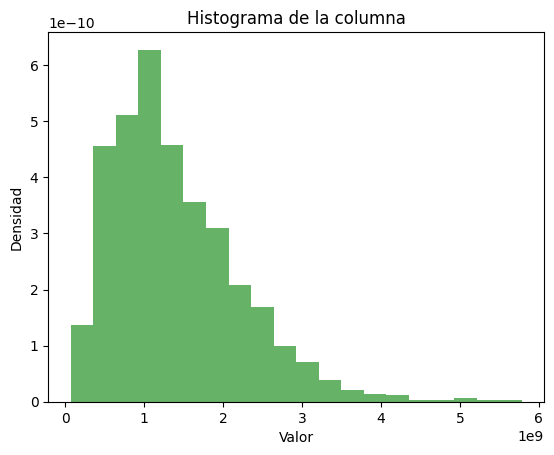

In [7]:
###Exploramos el resultado 
# Graficar el histograma de la columna
plt.hist(data['Valoracion'], bins=20, density=True, alpha=0.6, color='g')
plt.title('Histograma de la columna')
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.show()

In [8]:
# Ajustar la distribución gamma a los datos
shape, loc, scale = stats.gamma.fit(data['Valoracion'])

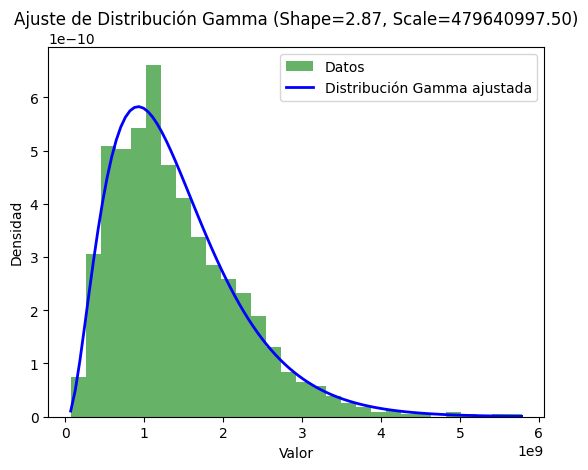

In [9]:
# Crear un rango de valores para la gráfica
x = np.linspace(min(data['Valoracion']), max(data['Valoracion']), 100)

# Obtener la función de densidad ajustada usando los parámetros obtenidos
pdf_gamma_ajustada = stats.gamma.pdf(x, shape, loc, scale)

# Graficar el histograma de los datos
plt.hist(data['Valoracion'], bins=30, density=True, alpha=0.6, color='g', label='Datos')

# Graficar la distribución gamma ajustada
plt.plot(x, pdf_gamma_ajustada, 'b-', linewidth=2, label='Distribución Gamma ajustada')

# Mostrar la gráfica
plt.title(f"Ajuste de Distribución Gamma (Shape={shape:.2f}, Scale={scale:.2f})")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()

In [10]:
#defina el intervalo de confianza de la distribucion al 5% 

shape = 2.87  # Nuevo parámetro de forma
scale = 479640997  # Nuevo parámetro de escala

quantile_5 = stats.gamma.ppf(0.05, a=shape, scale=scale)
quantile_95 = stats.gamma.ppf(0.95, a=shape, scale=scale)

print(f"Cuantil al 5%: {quantile_5}")
print(f"Cuantil al 95%: {quantile_95}")

#¿Que puede concluir de esto?

Cuantil al 5%: 360576647.60582757
Cuantil al 95%: 2926050013.444586


In [11]:
#calcule el valor del objetivo corporativo, si este es reducir el compromiso total por pensiones en al menos un 30%.
Total=data['Valoracion'].sum()
objetivo=Total*0.3
print('El objetivo del banco es reducir su compromiso por pensiones en al menos: ', objetivo)

El objetivo del banco es reducir su compromiso por pensiones en al menos:  506252650354.34235


In [47]:
###La probabilidad de aceptación de esta propuesta se comporta como una distribución Bernoulli de parametro P
###Considere que ud cambiará el valor de la renta por un monto hoy, que monto le daría a cada persona?
###Como consultor debe decidir el porcentaje minimo de aceptación del colectivo para que el proyecto sea viable. -> es decir la P min de la Bernoulli

df_sim=pd.DataFrame()
df_sim['key']=list(data.index)
df_sim['Valoracion']=list(data.Valoracion)

#Le daremos a cada persona el 70% del valor de la renta
d=0.8
df_sim['Pago_hoy']=(d)*df_sim['Valoracion']

sim=500
p=0.17

for i in range(500):  # Genera 500 simulaciones
    # Genera las muestras de la distribución de Bernoulli
    samples = np.random.binomial(1, p, len(df_sim))

    # Crea la nueva columna para la simulación
    df_sim['sim_' + str(i)] = samples

    # Aplica la lógica a cada fila: si el valor de la simulación es 1, toma Pago_hoy; si es 0, toma Valoracion
    df_sim['sim_' + str(i)] = df_sim.apply(
        lambda row: row['Pago_hoy'] if row['sim_' + str(i)] == 1 else row['Valoracion'], axis=1
    )

In [48]:
df_sim

,key,Valoracion,Pago_hoy,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,0,"1,017,456,036.16","813,964,828.92","813,964,828.92","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","813,964,828.92","813,964,828.92",...,"1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16"
1,1,"489,770,074.95","391,816,059.96","489,770,074.95","391,816,059.96","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95",...,"489,770,074.95","391,816,059.96","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95","489,770,074.95"
2,2,"881,797,559.19","705,438,047.36","705,438,047.36","705,438,047.36","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19",...,"881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","881,797,559.19","705,438,047.36","881,797,559.19"
3,3,"1,346,681,022.89","1,077,344,818.31","1,077,344,818.31","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,077,344,818.31","1,346,681,022.89",...,"1,077,344,818.31","1,346,681,022.89","1,077,344,818.31","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89"
4,4,"1,946,327,113.36","1,557,061,690.69","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,557,061,690.69","1,557,061,690.69","1,946,327,113.36","1,946,327,113.36",...,"1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,557,061,690.69","1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,"640,482,469.74","512,385,975.79","640,482,469.74","640,482,469.74","640,482,469.74","512,385,975.79","640,482,469.74","640,482,469.74","640,482,469.74",...,"640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74"
1196,1196,"913,985,755.27","731,188,604.22","913,985,755.27","913,985,755.27","731,188,604.22","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27",...,"913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27"
1197,1197,"846,745,509.27","677,396,407.41","846,745,509.27","846,745,509.27","677,396,407.41","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27",...,"846,745,509.27","846,745,509.27","677,396,407.41","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27","846,745,509.27"
1198,1198,"2,348,062,669.86","1,878,450,135.89","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86",...,"2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86"


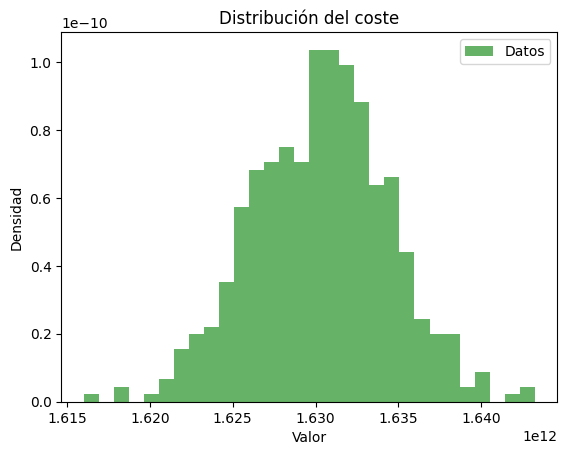

50565974446.071045

In [49]:
#Ahorro_final al 95% de confianza
cols=[col for col in df_sim.columns if 'sim_' in col]
resp=df_sim[cols].sum()
# Graficar el histograma de los datos
plt.hist(resp, bins=30, density=True, alpha=0.6, color='g', label='Datos')


# Mostrar la gráfica
plt.title(f"Distribución del coste")
plt.xlabel('Valor')
plt.ylabel('Densidad')
plt.legend()
plt.show()


cuantil_95 = np.percentile(resp, 95)
ahorro=Total-cuantil_95
ahorro